In [591]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
    
import os, sys, glob
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

import joypy
from matplotlib import cm

import pliers
from pliers.stimuli import TextStim
from pliers.extractors import PredefinedDictionaryExtractor, merge_results

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *
from tommy_utils import nlp, statistics
from preproc_utils import load_model_results, divide_nwp_dataframe, get_word_frequency, match_df_distributions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
EXPERIMENT_NAME = 'next-word-prediction'
EXPERIMENT_VERSION = 'final-multimodal-01'
TASK = 'wheretheressmoke'
# TASK = 'black'

gentle_dir = os.path.join(BASE_DIR, 'stimuli/gentle')
results_dir = os.path.join(BASE_DIR, 'derivatives/results/behavioral/')
preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed')

# set the directories we need
models_dir = os.path.join(BASE_DIR, 'derivatives/model-predictions')

word_model_name = 'fasttext'

## Functions

In [369]:
import matplotlib.colors as clr

def create_spoken_written_cmap(continuous=True):

    if continuous:
        spoken_written_cmap = clr.LinearSegmentedColormap.from_list('spoken-written', ['#005208', '#72D16B', '#808080', '#E4B266', '#623800'], N=256)
        spoken_written_cmap = spoken_written_cmap.reversed()
    else:
        spoken_written_cmap = sns.color_palette('BuPu', n_colors=9)
        spoken_written_cmap.insert(0, '#82C564')
        spoken_written_cmap.insert(1, '#F7CD84')
    return spoken_written_cmap

def get_ordered_accuracy(df_human_models, word_model_name='fasttext'):
    
    # Get order of models by binary accuracy
    ordered_accuracy = df_human_models.loc[:,['modality', f'{word_model_name}_avg_accuracy']] \
        .groupby(['modality']) \
        .mean() \
        .sort_values(by=f'{word_model_name}_avg_accuracy').index[::-1]

    return ordered_accuracy

def get_df_frequency(word_list, extractor, columns = ['stim_name', 'order', 'feature', 'value']):
    
    stims = [TextStim(text=word.lower(), order=i) for i, word in enumerate(word_list)]
    results = extractor.transform(stims)
    results = merge_results(results, extractor_names='column', format='long')

    # trim down to the columns to keep
    results = results[columns]
    results['stim_name'] = results['stim_name'].str.extract(r'\[(.*?)\]')

    return results

## Check frequency across all story words

### Functions for distribution matching

In [562]:
def load_df_preproc(preproc_dir, stim):
	# read from src dir for raw comparison
	df_preproc = pd.read_csv(os.path.join(preproc_dir, f'{stim}/src/{stim}_transcript-preprocessed.csv'))
	df_preproc['task'] = stim
	return df_preproc


In [601]:
ALPHA = 0.1
N_ITER = 25

written_stories = ['demon', 'keats']
spoken_stories = ['wheretheressmoke', 'howtodraw', 'odetostepfather']

stim_list = ['wheretheressmoke', 'howtodraw', 'odetostepfather', 'demon', 'keats']

# load the spoken stimuli
df_spoken = [load_df_preproc(preproc_dir, stim) for stim in spoken_stories]
df_spoken = pd.concat(df_spoken).reset_index(drop=True)
df_spoken['type'] = 'spoken'

# # trip to nwp words
df_nwp_spoken = df_spoken[df_spoken['NWP_Candidate']].dropna()
df_written = []

for stim in written_stories:
    df_stim = load_df_preproc(preproc_dir, stim)
    df_nwp_stim = df_stim[df_stim['NWP_Candidate']].dropna()
    
    # make sure something is returned
    df_nwp_stim, t_stat, p_val = match_df_distributions(df_nwp_stim, df_nwp_spoken, source_col='Lg10WF', target_col='Lg10WF', alpha=ALPHA, n_iter=N_ITER)

    print (t_stat, p_val)
    # grab the frequency indices --> match them to the original dataframe
    frequency_indices = df_nwp_stim.index.to_numpy()
    frequency_filter = df_stim.index.isin(frequency_indices)

    # if it's in the frequency filter --> set the frequency filter, otherwise remove it as a possible candidate
    df_stim.loc[frequency_filter, 'Frequency_Filter'] = True
    df_stim.loc[~frequency_filter, ['NWP_Candidate', 'Frequency_Filter']] = False

    df_written.append(df_nwp_stim)

df_written = pd.concat(df_written).reset_index(drop=True)
df_written['type'] = 'written'

df_task_frequencies = pd.concat([df_spoken, df_written]).reset_index(drop=True)
df_task_frequencies = df_task_frequencies[df_task_frequencies['NWP_Candidate']].dropna()

Completed iter 001
Completed iter 002
Completed iter 003
Completed iter 004
Completed iter 005
Completed iter 006
Completed iter 007
Completed iter 008
Completed iter 009
Completed iter 010
Completed iter 011
Completed iter 012
Completed iter 013
Completed iter 014
Completed iter 015
Completed iter 016
Completed iter 017
Completed iter 018
Completed iter 019
Completed iter 020
Completed iter 021
Completed iter 022
Completed iter 023
Completed iter 024
Completed iter 025
nan nan
Updating distribution -- retained 68.88% of samples
Completed iter 001
Completed iter 002
Completed iter 003
Completed iter 004
Completed iter 005
Completed iter 006
Completed iter 007
Completed iter 008
Completed iter 009
Completed iter 010
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/scratch/ipykernel_3071419/3361918908.py", line 23, in <module>
    df_nwp_stim, t_stat, p_val = match_df_distributions(df_nwp_stim, df_nwp_spoken, source_col='Lg10WF', target_col='Lg10WF', alpha=ALPHA, n_iter=N_ITER)
  File "/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py", line 573, in match_df_distributions
    max_source_pdf = np.max(target_dist.pdf(source_data[source_indices]))
  File "/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 555, in pdf
    return self.dist.pdf(x, *self.args, **self.kwds)
  File "/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/dark_matter/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 1

In [606]:
df_spoken = df_task_frequencies[df_task_frequencies['task'].isin(spoken_stories)].dropna()
df_written = df_task_frequencies[df_task_frequencies['task'].isin(written_stories)].dropna()

info = ttest_ind(df_spoken[variable], df_written[variable])

### Plot for each stimulus word frequency distribution

TtestResult(statistic=1.8207348513577641, pvalue=0.06872241690384673, df=3970.0)

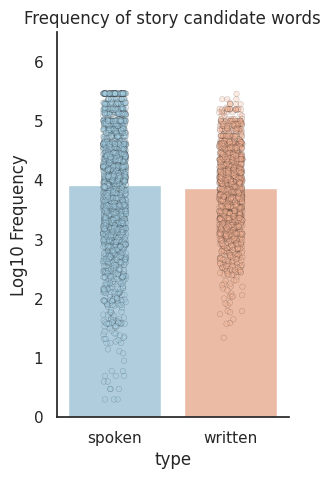

In [558]:
from scipy.stats import ttest_ind

sns.set(style='white', rc={'figure.figsize':(3,5)})

variable = 'Lg10WF'

cmap = sns.color_palette('RdBu_r', n_colors=2)

df_spoken = df_task_frequencies[df_task_frequencies['task'].isin(spoken_stories)].dropna()
df_written = df_task_frequencies[df_task_frequencies['task'].isin(written_stories)].dropna()

ax = sns.barplot(df_task_frequencies, x='type', y=variable, palette=cmap)

ax = sns.stripplot(data=df_task_frequencies, x='type', y=variable, palette=cmap, 
                   size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)


plt.ylim([0,6.5])
plt.ylabel('Log10 Frequency')
plt.title('Frequency of story candidate words')
sns.despine()

ttest_ind(df_spoken[variable], df_written[variable])

Text(0.5, 1.0, 'Subsampled candidate words - ZipF Log10 Frequency')

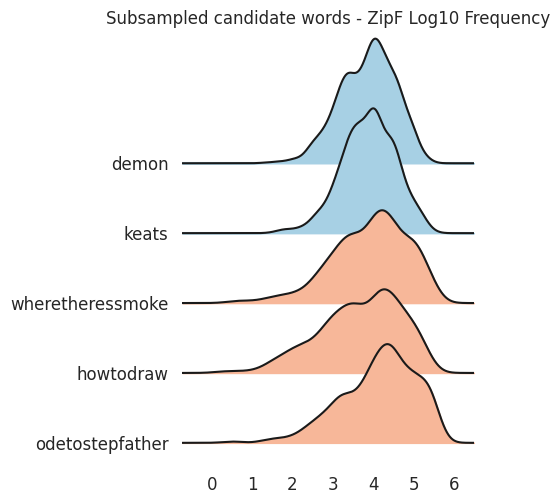

In [559]:
sns.set(style='white', rc={'figure.figsize':(5,5)})

# reorder the dataframe by the order of modalities
ordered_modalities = written_stories + spoken_stories
df_task_frequencies['task'] = pd.Categorical(df_task_frequencies['task'], categories=ordered_modalities, ordered=True)

cmap = sns.color_palette('RdBu_r', n_colors=5)
cmap = [cmap[1]] * len(written_stories) + [cmap[-2]] * len(spoken_stories)

fig, axes = joypy.joyplot(df_task_frequencies, column=variable, by='task', color=cmap)
plt.title(f'Subsampled candidate words - ZipF Log10 Frequency')

## Look at divided dataframe frequency stats

In [641]:
extractor = PredefinedDictionaryExtractor(['subtlexusfrequency/Lg10WF'],  missing=np.nan)

all_divided = []

for stim in stim_list:
    df_selected = pd.read_csv(os.path.join(preproc_dir, stim, f'{stim}_transcript-selected.csv'))
    df_selected = df_selected[df_selected['NWP_Candidate']]
    df_results = get_df_frequency(df_selected['Word_Written'].tolist(), extractor)
    
    df_results['task'] = stim

    if stim in written_stories:
        df_results['type'] = 'written'
    else:
        df_results['type'] = 'spoken'

    all_divided.append(df_results)

df_divided = pd.concat(all_divided).reset_index(drop=True)
df_divided = df_divided.dropna()

Stim: 237it [00:00, 7262.63it/s]
Stim: 241it [00:00, 7941.57it/s]
Stim: 263it [00:00, 8034.89it/s]
Stim: 318it [00:00, 8236.67it/s]
Stim: 214it [00:00, 7989.08it/s]


TtestResult(statistic=1.1454354061421894, pvalue=0.25224480569808677, df=1269.0)

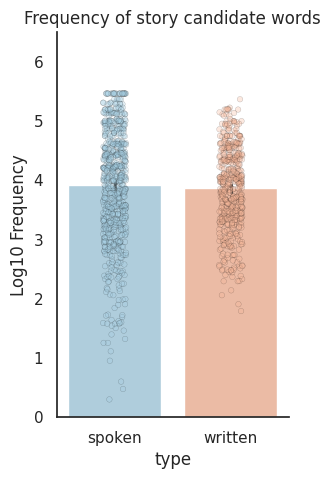

In [642]:
from scipy.stats import ttest_ind

sns.set(style='white', rc={'figure.figsize':(3,5)})

variable = 'value'

cmap = sns.color_palette('RdBu_r', n_colors=2)

df_spoken = df_divided[df_divided['task'].isin(spoken_stories)].dropna()
df_written = df_divided[df_divided['task'].isin(written_stories)].dropna()

ax = sns.barplot(df_divided, x='type', y=variable, palette=cmap)

ax = sns.stripplot(data=df_divided, x='type', y=variable, palette=cmap, 
                   size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)


plt.ylim([0,6.5])
plt.ylabel('Log10 Frequency')
plt.title('Frequency of story candidate words')
sns.despine()

ttest_ind(df_spoken[variable], df_written[variable])

## Load human model results collapsed

In [256]:
# something here
compiled_results_fn = os.path.join(results_dir, f'task-{TASK}_group-analyzed-behavior_human-model-lemmatized.csv')
df_human_models = pd.read_csv(compiled_results_fn)

# make a new dataframe and drop missing values --> this is specifically for stats
df_anova = df_human_models.copy()
df_anova = df_anova[~df_anova[f'{word_model_name}_avg_accuracy'].isna()]

## Analyze the frequency statistics of word usage

In [315]:
all_modality_frequencies = []

extractor = PredefinedDictionaryExtractor(['subtlexusfrequency/Lg10WF'],  missing=np.nan)

for mod, df_modality in df_human_models.groupby('modality'):

    columns = ['stim_name', 'feature', 'value']

    # replace any missing responses with space
    df_modality = df_modality.fillna(' ').reset_index(drop=True)

    df_results = get_df_frequency(df_modality['top_pred'].tolist(), extractor)
    df_results['modality'] = mod

    # find which indices succeeded
    idxs = df_results['order']
    df_results[['top_prob', 'predictability']] = df_modality.loc[idxs, ['top_prob', 'predictability']]
    
    all_modality_frequencies.append(df_results)

df_ground_truth = get_df_frequency(df_modality['ground_truth'].tolist(), extractor)
df_ground_truth['modality'] = 'ground_truth'

all_modality_frequencies.append(df_ground_truth)
    
df_frequencies = pd.concat(all_modality_frequencies).reset_index(drop=True)

Stim: 237it [00:00, 251213.05it/s]
Stim: 237it [00:00, 257659.42it/s]
Stim: 237it [00:00, 248574.66it/s]
Stim: 237it [00:00, 254297.79it/s]
Stim: 237it [00:00, 253454.88it/s]
Stim: 237it [00:00, 254167.74it/s]
Stim: 237it [00:00, 252489.22it/s]
Stim: 237it [00:00, 254753.98it/s]
Stim: 237it [00:00, 254232.75it/s]
Stim: 237it [00:00, 253519.52it/s]
Stim: 237it [00:00, 250012.59it/s]
Stim: 237it [00:00, 252041.09it/s]


### Plot by stimulus

In [ ]:
# cmap = create_spoken_written_cmap(continuous=False)
# cmap.insert(len(cmap)+1, '#808080')

fig, axes = joypy.joyplot(df_frequencies, column='value', by='modality', color=cmap)
plt.title(f'{TASK} word prediction - ZipF Log10 Frequency')

## Set model names and order

In [288]:
# get all MLM models except BERT
MLM_MODELS = list(nlp.MLM_MODELS_DICT.keys())[1:]
CLM_MODELS = list(nlp.CLM_MODELS_DICT.keys()) 
model_names = CLM_MODELS + MLM_MODELS

print (f'Loading the following models')
print (f'MLM models: {MLM_MODELS}')
print (f'CLM models: {CLM_MODELS}')

ordered_accuracy = get_ordered_accuracy(df_human_models)

# now order the models and conditions for plotting
human_conditions = ['audio', 'text']
ordered_models = [item for item in ordered_accuracy if item not in ['audio', 'text', *MLM_MODELS]]
ordered_modalities = human_conditions + ordered_models + MLM_MODELS + ['ground_truth']

# reorder the dataframe by the order of modalities
df_frequencies['modality'] = pd.Categorical(df_frequencies['modality'], categories=ordered_modalities, ordered=True)

Loading the following models
MLM models: ['roberta', 'electra', 'xlm-prophetnet']
CLM models: ['bloom', 'gpt2', 'gpt2-xl', 'gpt-neo-x', 'llama2', 'mistral']


Text(0.5, 1.0, 'wheretheressmoke word prediction - ZipF Log10 Frequency')

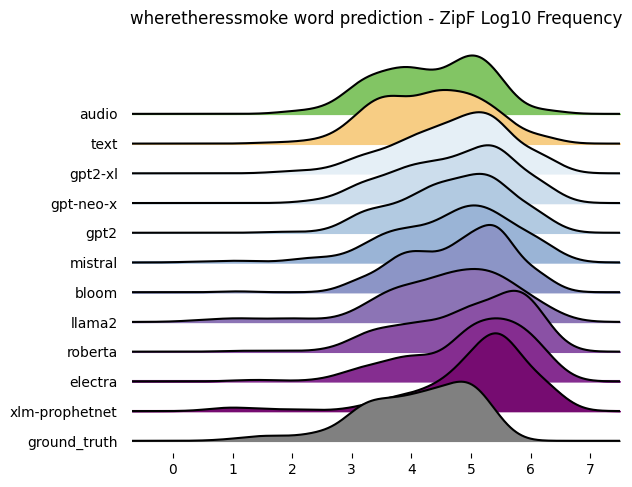

In [289]:
cmap = create_spoken_written_cmap(continuous=False)
cmap.insert(len(cmap)+1, '#808080')

fig, axes = joypy.joyplot(df_frequencies, column='value', by='modality', color=cmap)
plt.title(f'{TASK} word prediction - ZipF Log10 Frequency')

### Test frequency vs. predictability relationship

In [322]:
df_test = df_frequencies[df_frequencies['modality'] != 'ground_truth']
df_ground_truth = df_frequencies[df_frequencies['modality'] == 'ground_truth'].reset_index(drop=True)

Text(0.5, 0.98, 'Ground Truth Frequency x Predictability relationship')

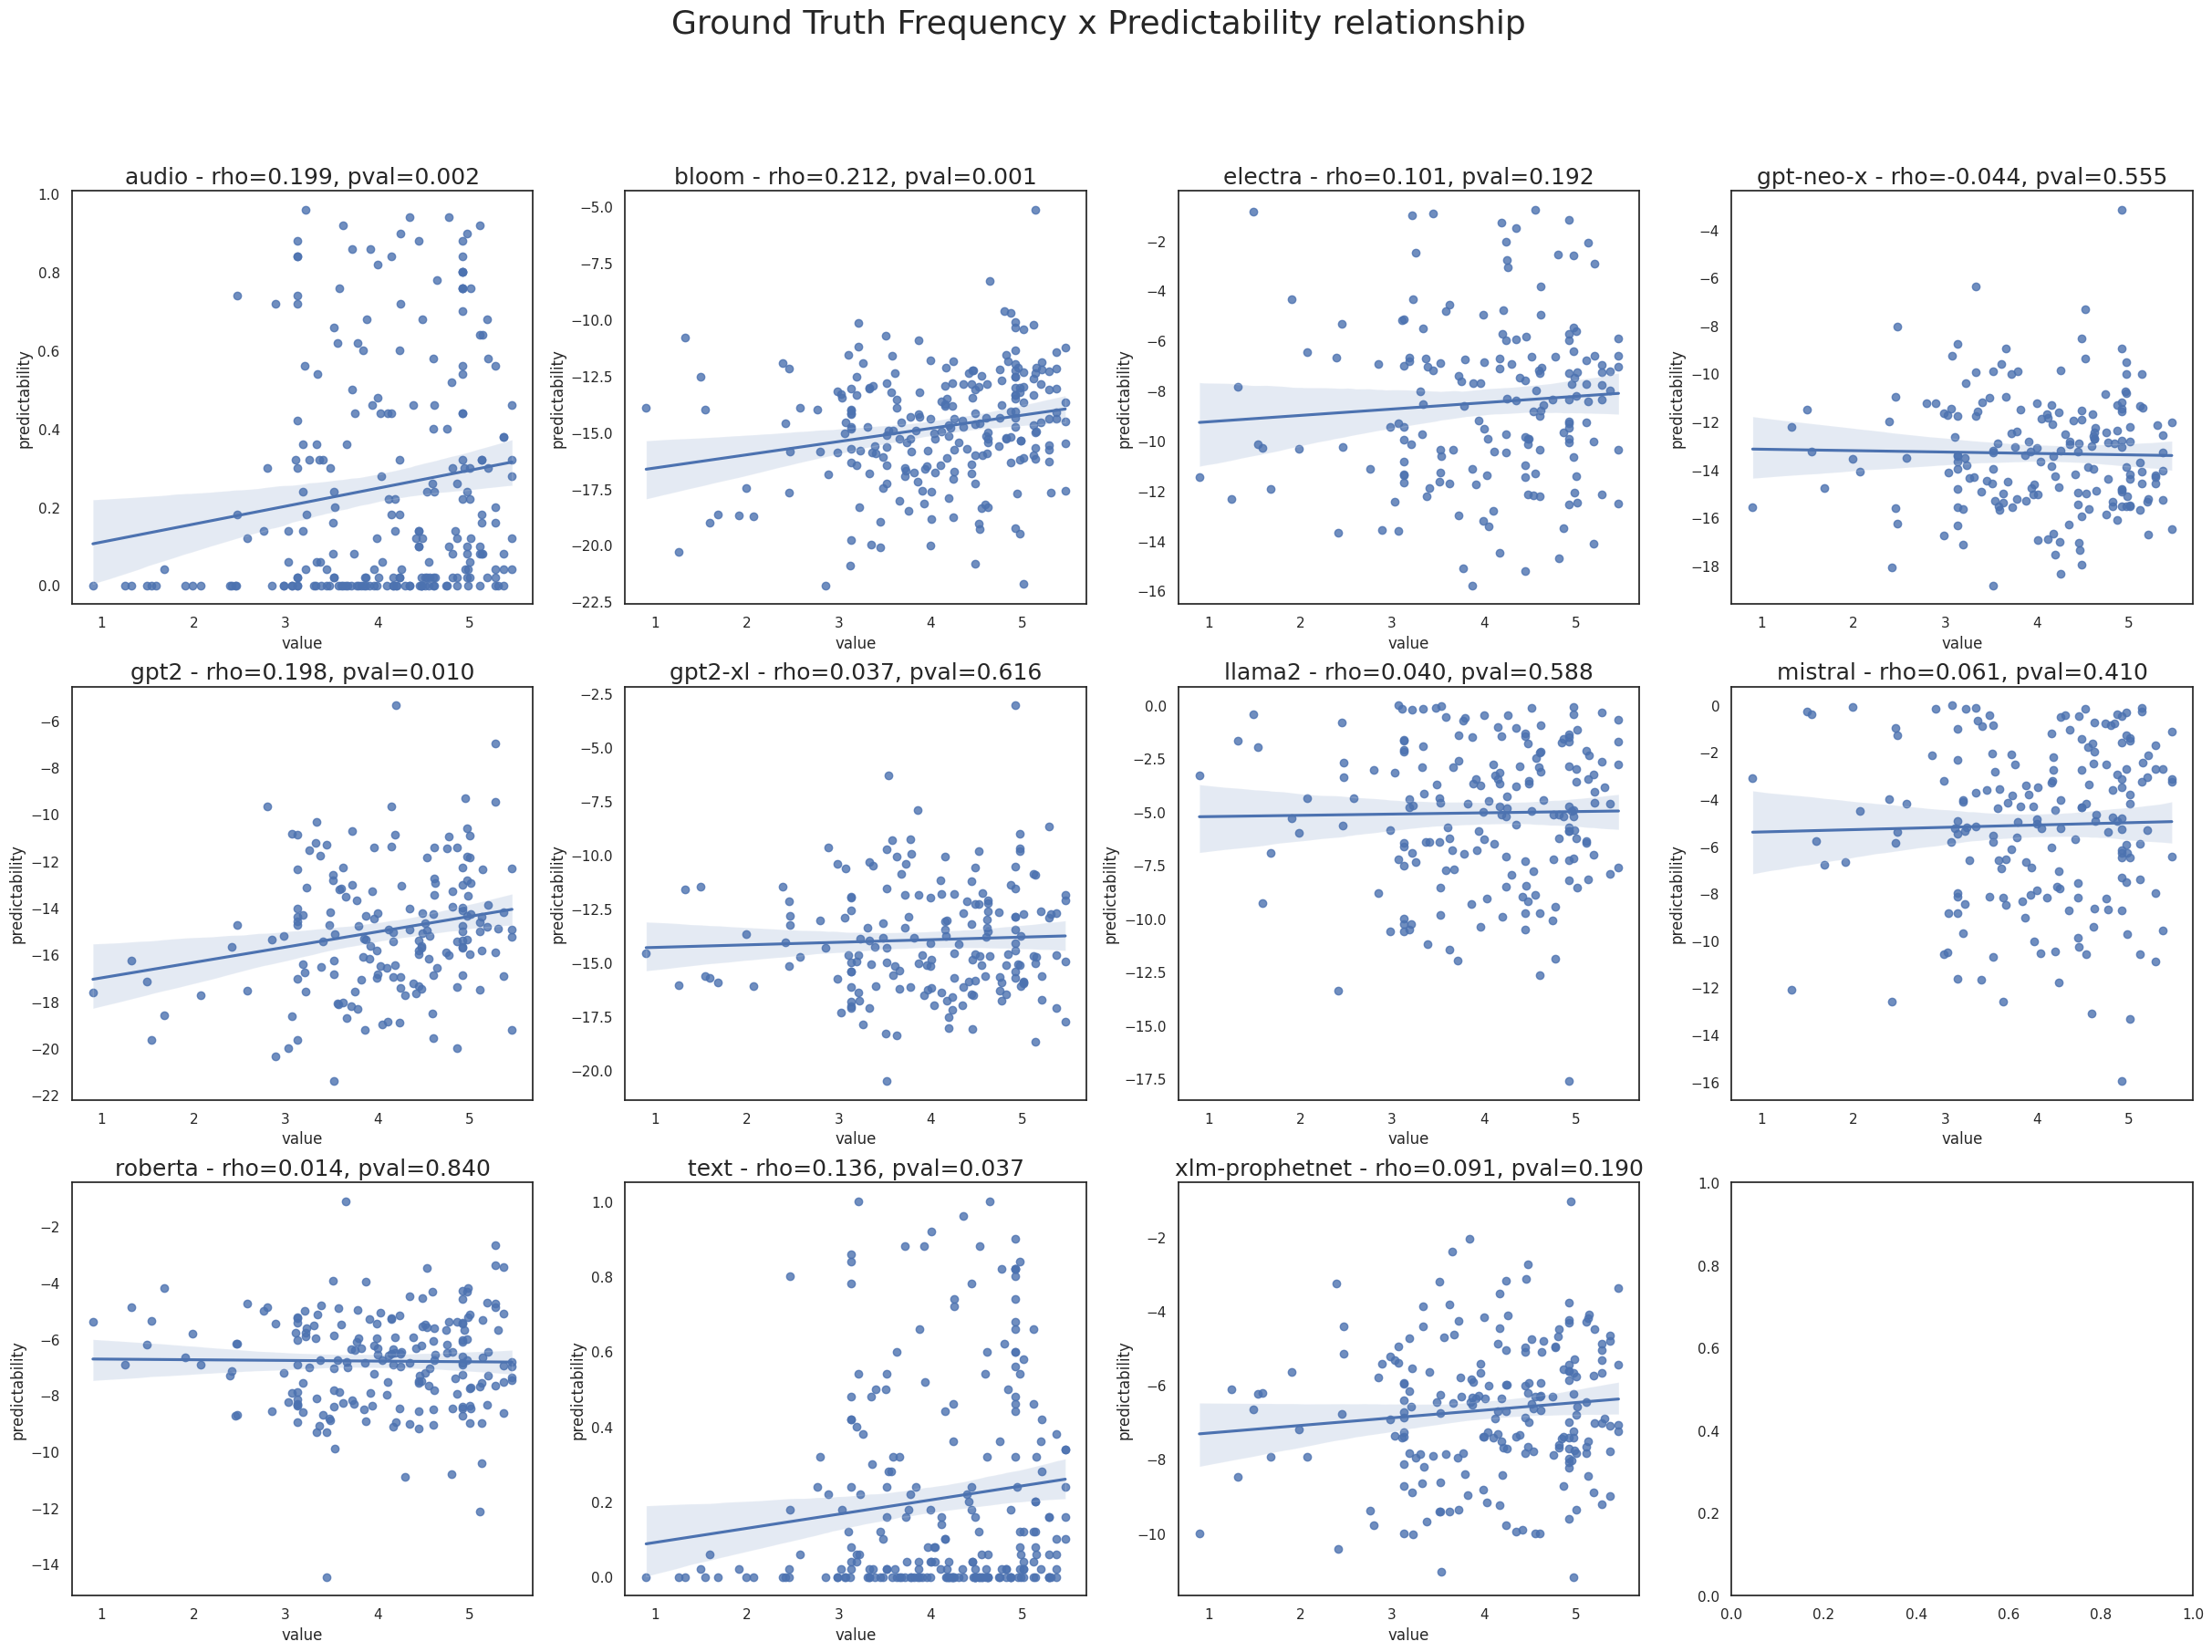

In [331]:
sns.set(style='white', rc={ "axes.titlesize":18}, font_scale=1)

fig, axes = plt.subplots(3, 4, figsize=(30, 20))
axes = axes.flatten()

x = 'value'
y = 'predictability'

for ax, (modality, df) in zip(axes, df_test.groupby('modality')):

    idxs = df['order']
    df['value'] = df_ground_truth.loc[idxs, 'value'].to_numpy()
    
    df = df.dropna()
    
    if modality not in ['audio', 'text']:
        df[y] = df[y].apply(statistics.log_odds)
    
    sns.regplot(df, x=x, y=y, ax=ax)

    r, pval = stats.spearmanr(df[x], df[y])

    ax.title.set_text(f'{modality} - rho={r:.3f}, pval={pval:.3f}')

plt.suptitle(f'Ground Truth Frequency x {y.capitalize()} relationship', fontsize=26)
# plt.tight_layout()